In [ ]:
!pip install pyspark -q

!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.5
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.26
Branch HEAD
Compiled by user ubuntu on 2025-02-23T20:30:46Z
Revision 7c29c664cdc9321205a98a14858aaf8daaa19db2
Url https://github.com/apache/spark
Type --help for more information.


In [ ]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Read data into a Spark dataframe

In [ ]:
#!ls /content/drive/MyDrive

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName("IMDb Details")\
        .getOrCreate()

In [ ]:
# Read Parquet file into a Spark DataFrame
df_parquet = spark.read.parquet('/content/drive/MyDrive/movie-recommendation-system/User-Movie-data.parquet')

In [ ]:
df_parquet.show(5)
df_parquet.count()

+------+--------------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+----------------+
|imdbId|               Title|UserID|MovieID|Genres|Rating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|      directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|        director|
+------+--------------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+----------------+
|160009|Art of War, The (...|    17|   3879|Action|     4| 978158689|2000-12-30 06:44:49|     M| 50|         1|   95350|  2.90989|Christian Duguay|   3879|Wesley Snipes, Do...| The Art of War|     117|        5.7|Shaw is an operat...|Christian 

916355

### This dataset includes movie-related information such as movie and user IDs, ratings, genres, and movie details (e.g., title, director, plot). It also contains user demographics (e.g., gender, age, occupation), timestamps, and additional movie attributes like runtime, IMDb rating, and cast. Some fields allow missing values.

In [ ]:
df_parquet.printSchema()
df_parquet.count()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: double (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- director: string (nullable = true)



916355

In [ ]:
from pyspark.sql import functions as F

#Rename 'Rating' to 'UserRating' and convert 'UserRating' and 'avgRating' to integer type
df_parquet_cleaned = df_parquet \
    .withColumnRenamed('Rating', 'UserRating') \
    .withColumn('UserRating', F.col('UserRating').cast('int')) \
    .withColumn('avgRating', F.col('avgRating').cast('int'))

#dropping the 'director' column
df_parquet_cleaned = df_parquet_cleaned.drop('director')
df_parquet_cleaned.show(5)

+------+--------------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+
|imdbId|               Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|      directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|
+------+--------------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+
|160009|Art of War, The (...|    17|   3879|Action|         4| 978158689|2000-12-30 06:44:49|     M| 50|         1|   95350|        2|Christian Duguay|   3879|Wesley Snipes, Do...| The Art of War|     117|        5.7|Shaw is an operat...|
|160009|Art of War, The (...|    90|   3879|

##### This code defines a User Defined Function (UDF) to map occupation codes to their corresponding occupation names using a dictionary. It then applies this UDF to a DataFrame (`df_parquet_cleaned`) to add a new column, `Occupation_Name`, and displays the first 5 rows of the updated DataFrame. I picked this up from the meta data
   Occupation Codes
   
    *  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [ ]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import StringType

# Occupation mapping dictionary
occupation_dict = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# User Defined Function to map the occupation code to the occupation name
occupation_udf = udf(lambda x: occupation_dict.get(x, "Unknown"), StringType())

# Adding the occupation name to the Parquet DataFrame
df_parquet_cleaned = df_parquet_cleaned.withColumn("Occupation_Name", occupation_udf(col("Occupation")))

df_parquet_cleaned.show(5)


+------+--------------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|imdbId|               Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|      directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|
+------+--------------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+----------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|160009|Art of War, The (...|    17|   3879|Action|         4| 978158689|2000-12-30 06:44:49|     M| 50|         1|   95350|        2|Christian Duguay|   3879|Wesley Snipes, Do...| The Art of War|     117|        5.7|Sha

In [ ]:
# Dropping  avgRating as its in the schema twice and changing rating_imdb to integet type
df_parquet_cleaned = df_parquet_cleaned.drop('avgRating')
df_parquet_cleaned = df_parquet_cleaned.withColumn('rating_imdb', df_parquet_cleaned['rating_imdb'].cast('int'))

In [ ]:
# Check for missing values
df_parquet_cleaned.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_parquet_cleaned.columns]).show()
# Drop rows with missing UserID, MovieID, or UserRating
df_parquet_cleaned = df_parquet_cleaned.dropna(subset=["UserID", "MovieID", "UserRating"])


+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|imdbId|Title|UserID|MovieID|Genres|UserRating|Timestamp|date_time|Gender|Age|Occupation|Zip_Code|directedBy|item_id|starring|localized_title|runtimes|rating_imdb|plot_outline|Occupation_Name|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|     0|    0|     0|      0|     0|         0|        0|        0|     0|  0|         0|       0|        31|      0|     238|              0|       0|          1|           0|              0|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+



In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



#### Below shows a simple distribution of IMDb rating values.

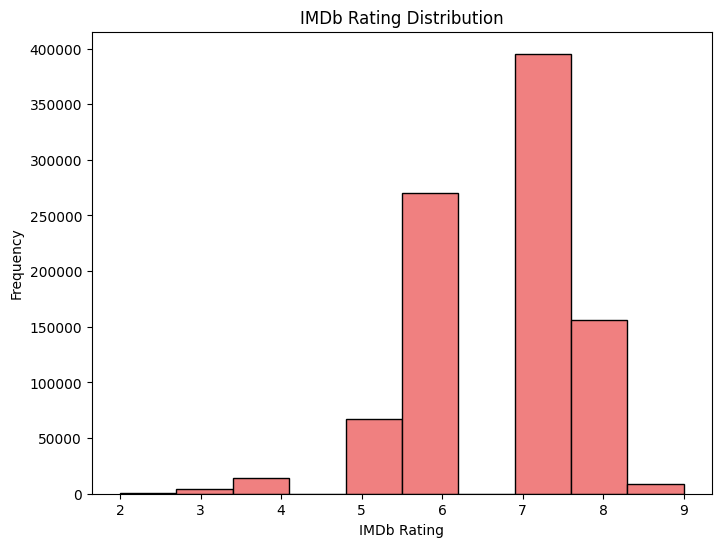

In [ ]:
import matplotlib.pyplot as plt

#converting spark dataframe to pandas

rating_imdb_data = df_parquet_cleaned.select('rating_imdb').toPandas() # This collects all data from the distributed Spark DataFrame into a single Pandas DataFrame in memory.
                                                                       # Warning: If the Spark DataFrame is too large, this can cause memory issues since Pandas loads everything into RAM.
plt.figure(figsize=(8, 6))
plt.hist(rating_imdb_data['rating_imdb'], bins=10, color='lightcoral', edgecolor='black')
plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


scaler = MinMaxScaler()

# Normalize ratings
user_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('UserRating').toPandas())
imdb_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('rating_imdb').toPandas())

##### Below is a heatmap of genre preference by zip code region. This shows us the most popular genres across our geographic feature. The top 3 genres across the top 20 most active regions are Drama, Comedy, and Action.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_rows = df_parquet.count()

# calculate middle index for splitting due to memory limitations
half_rows = total_rows // 2

# Create a copy of the cleaned dataframe
df = df_parquet_cleaned.limit(half_rows).toPandas()

# Split the Genres column into separate columns
genres_split = df['Genres'].str.get_dummies(sep='|')

# Merge the genres back with the original DataFrame
df = pd.concat([df, genres_split], axis=1)

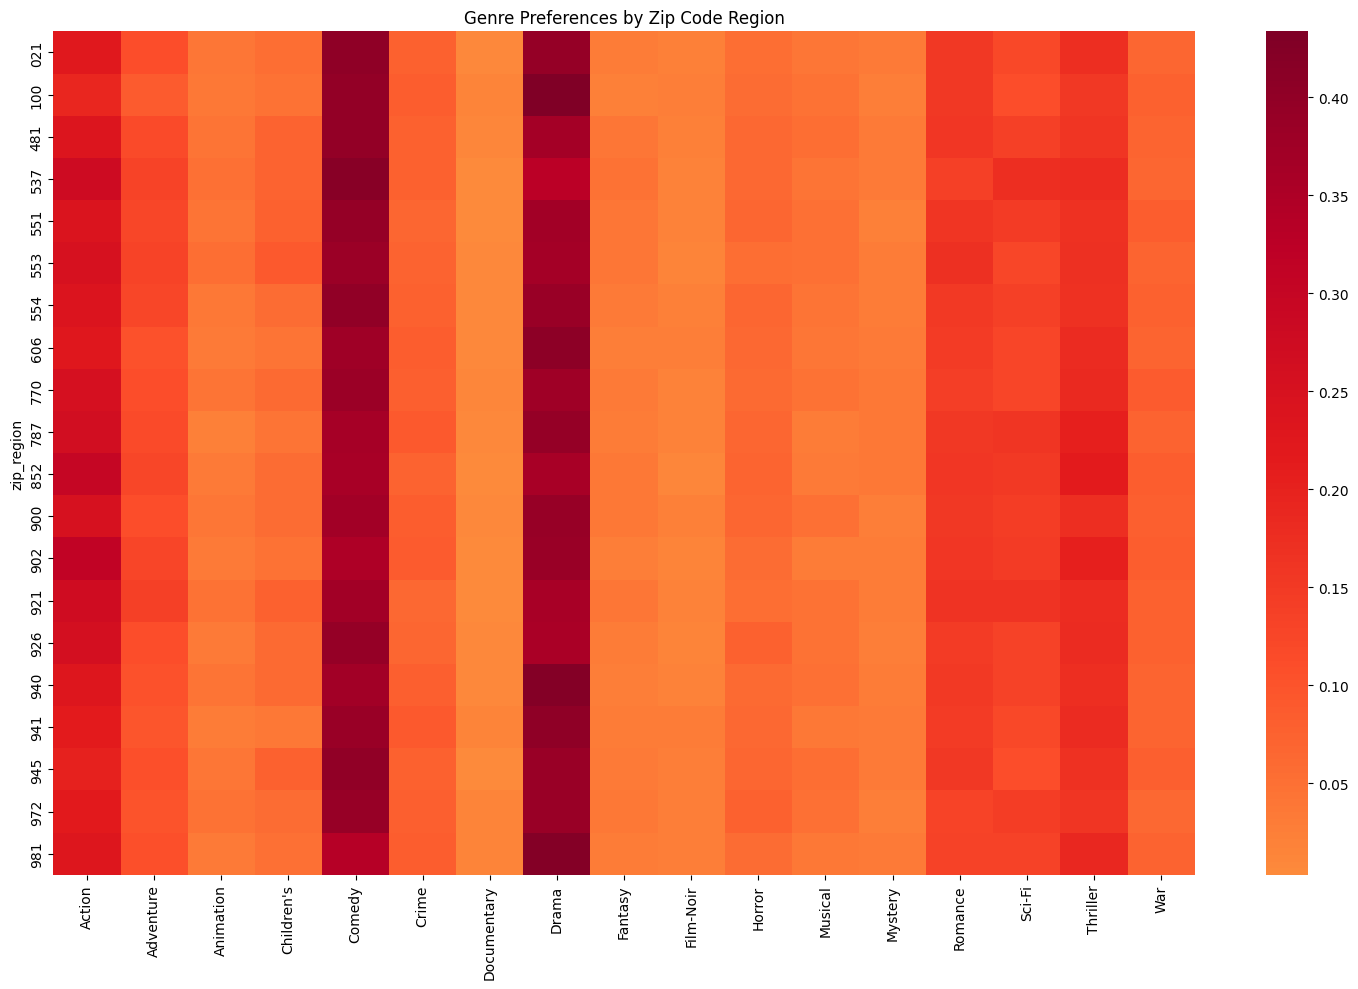

In [ ]:
# Extract first 3 digits of zipcode for regional analysis
df['zip_region'] = df['Zip_Code'].astype(str).str[:3]

genre_cols = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
             'Thriller', 'War']

# Filter to the top 20 most active regions in the dataset
'''
"Active regions" in this case are defined as regions with many users rating many movies
who were from the region, making the region's count high in our dataset.
'''
top_regions = df['zip_region'].value_counts().head(20).index
region_genre_dist = df[df['zip_region'].isin(top_regions)].groupby('zip_region')[genre_cols].mean()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(region_genre_dist, cmap='YlOrRd', center=0)
plt.title('Genre Preferences by Zip Code Region')
plt.tight_layout()
plt.show()

This KDE plot compares the **distribution of normalized user ratings and IMDb ratings**, revealing key differences in rating behaviors. The sharp peaks in both curves suggest that ratings are **not smoothly distributed**, but instead cluster at specific values. This implies that users and IMDb often assign **discrete ratings**, such as 1–10, rather than spreading their scores continuously.  

The blue curve (**User Ratings**) and the orange curve (**IMDb Ratings**) have peaks at different points, indicating **differences in rating preferences**. IMDb ratings show **higher density** around 0.6 and 0.8, suggesting that users on IMDb tend to favor specific values. Meanwhile, user ratings appear **more spread out**, showing a different rating behavior.  

The distribution is **non-Gaussian**, meaning it does not follow a traditional bell curve. Instead, the multiple sharp peaks suggest **categorical or fixed-step ratings**, which KDE may not represent optimally. The plot could be improved by adjusting the **bandwidth (smoothing parameter)** to reduce the extreme peaks or by using a **histogram** instead, which better suits discrete data.

<ipython-input-17-46d18668090a>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(
<ipython-input-17-46d18668090a>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


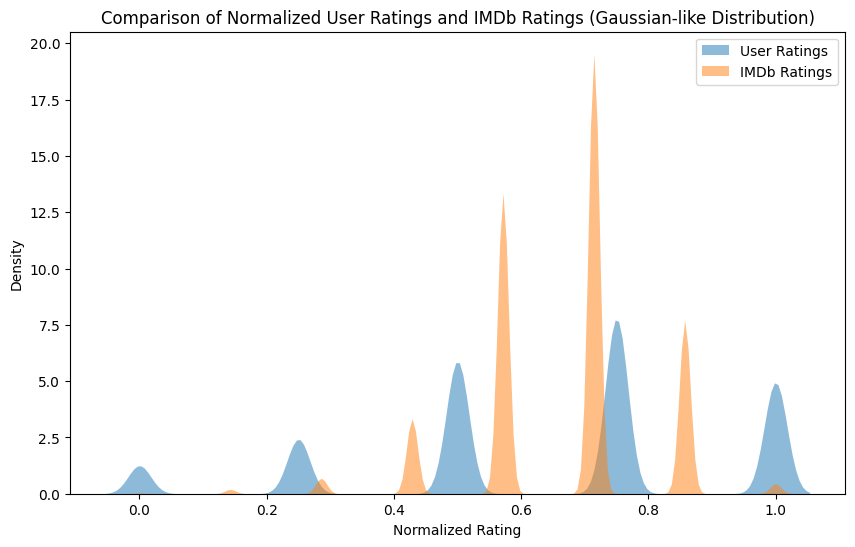

In [ ]:
ratings_df = pd.DataFrame({
    'UserRatings': user_ratings_normalized.flatten(),
    'IMDbRatings': imdb_ratings_normalized.flatten()
})
# Plotting gaussian-like distributions of both normalized ratings using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=ratings_df, x="UserRatings", fill=True, common_norm=False,
    palette="Blues", alpha=.5, linewidth=0, label='User Ratings'
)

sns.kdeplot(
            data=ratings_df, x="IMDbRatings", fill=True, common_norm=False,
            palette="YlOrBr", alpha=.5, linewidth=0, label='IMDb Ratings'
        )

plt.title('Comparison of Normalized User Ratings and IMDb Ratings (Gaussian-like Distribution)')
plt.xlabel('Normalized Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

##### Below table shows that programmers have the highest average user rating of 3.64, while writers have the lowest at 3.48. Occupations with large user bases, such as college/grad students and others/not specified, have average ratings around 3.53, possibly reflecting a wider range of opinions.

##### Smaller groups like technicians/engineers and sales/marketing show higher ratings of 3.61, suggesting more positive feedback in specialized roles. Occupations like academic/educators and executives/managers have moderate ratings, around 3.56–3.59, indicating balanced user sentiment. Overall, technical and specialized roles tend to receive higher ratings than larger, diverse groups.

In [ ]:
# Group by Occupation and calculate average user rating for each occupation
occupation_avg_rating = df_parquet_cleaned.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("Avg_UserRating"),  # Calculate average user rating
        F.count("UserID").alias("User_Count")  # Count the number of users in each occupation
       )

# Sort by User_Count in descending order and take the top 10 occupations
top_10_occupations = occupation_avg_rating.orderBy(F.col("User_Count").desc()).limit(10)
top_10_occupations.show()


+--------------------+------------------+----------+
|     Occupation_Name|    Avg_UserRating|User_Count|
+--------------------+------------------+----------+
|college/grad student| 3.526505472553997|    120145|
|other or not spec...|3.5293792826485277|    119523|
|executive/managerial|3.5902248652666793|     96858|
|   academic/educator| 3.566375183506734|     78335|
| technician/engineer| 3.606288684574244|     66564|
|              writer|3.4826946510739685|     54983|
|          programmer|3.6414716748768474|     51968|
|              artist| 3.556769804696072|     45570|
|     sales/marketing|3.6084449158159884|     45258|
|       self-employed| 3.588229714990278|     42174|
+--------------------+------------------+----------+



##### The plot highlights the top 10 occupations by user count, with "college/grad student" having the highest count (120,145) and "self-employed" the lowest (42,174). Occupations with higher user counts, such as "executive/managerial" and "academic/educator," suggest more stable ratings, while those with lower counts may introduce more variability.

<ipython-input-19-4d4b1cd332ed>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-19-4d4b1cd332ed>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-19-4d4b1cd332ed>:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


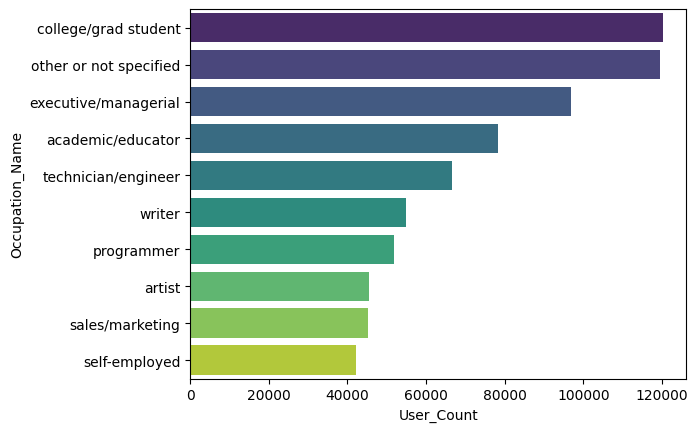

ValueError: Image size of 111781451x5618 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x800 with 1 Axes>

In [ ]:
top_10_occupations_pd = top_10_occupations.toPandas()

sns.barplot(
    x="User_Count", y="Occupation_Name", data=top_10_occupations_pd,
    palette="viridis", orient="h", ci=None
)

plt.figure(figsize=(12, 8))
plt.title('Top 10 Occupations by User Count and Average Rating', fontsize=16)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Occupation Name', fontsize=12)

for index, value in enumerate(top_10_occupations_pd['User_Count']):
    plt.text(value + 50, index, str(value), color='black', ha="center", va="center")

plt.tight_layout()
plt.show()


##### The heatmap matrix below presents the average user ratings for different genre combinations across several occupations. Each occupation is associated with specific genres, and the values represent the average rating users have given to movies in these genres.

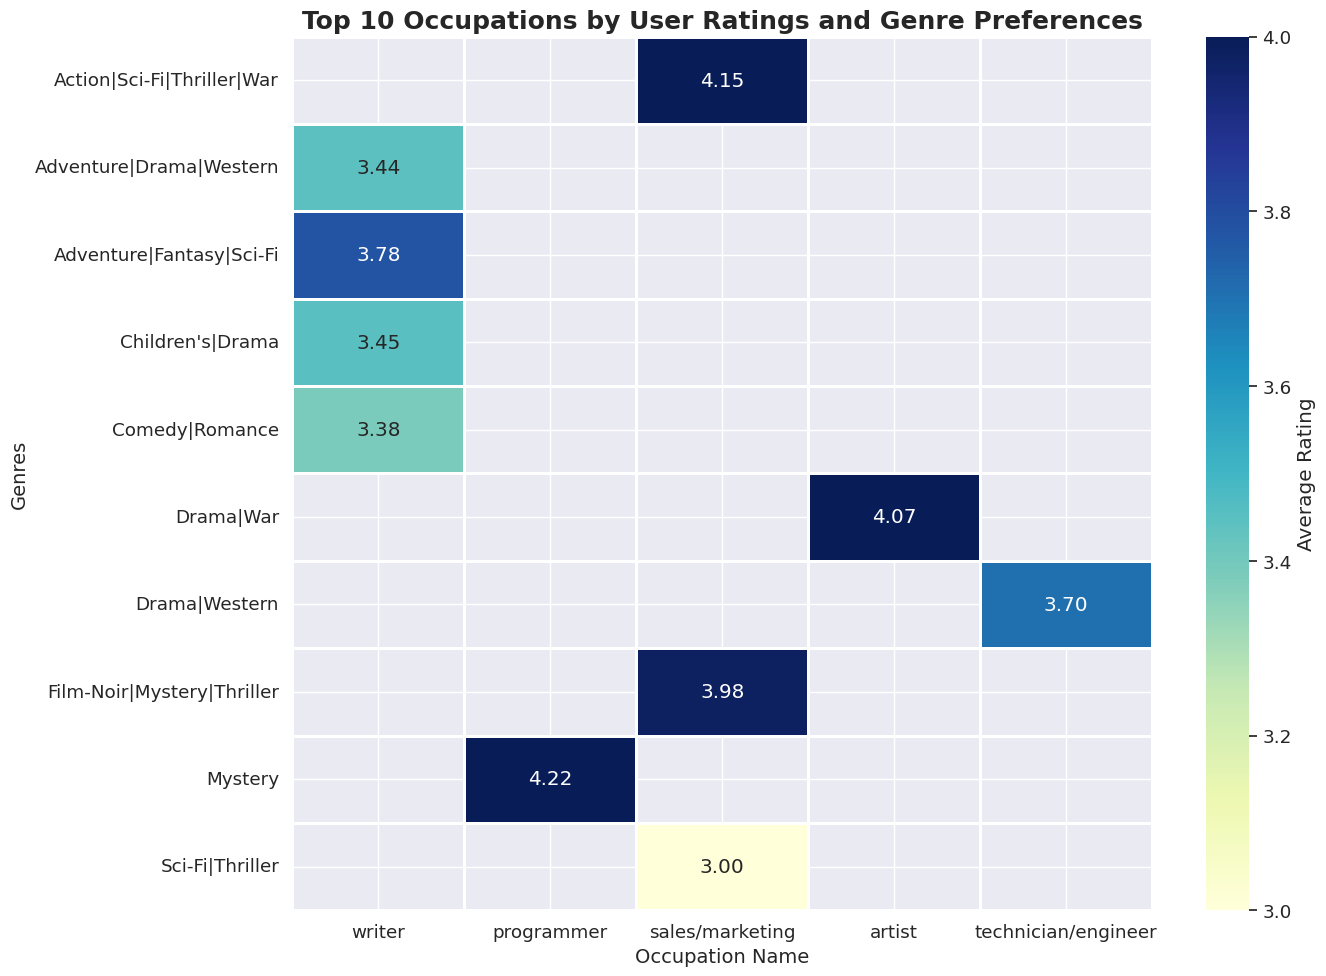

Occupation_Name               writer  programmer  sales/marketing    artist  \
Action|Sci-Fi|Thriller|War       NaN         NaN         4.147727       NaN   
Adventure|Drama|Western     3.442857         NaN              NaN       NaN   
Adventure|Fantasy|Sci-Fi    3.780822         NaN              NaN       NaN   
Children's|Drama            3.450549         NaN              NaN       NaN   
Comedy|Romance              3.384952         NaN              NaN       NaN   
Drama|War                        NaN         NaN              NaN  4.067873   
Drama|Western                    NaN         NaN              NaN       NaN   
Film-Noir|Mystery|Thriller       NaN         NaN         3.980000       NaN   
Mystery                          NaN       4.225              NaN       NaN   
Sci-Fi|Thriller                  NaN         NaN         3.000000       NaN   

Occupation_Name             technician/engineer  
Action|Sci-Fi|Thriller|War                  NaN  
Adventure|Drama|Western       

In [ ]:

# Calculating the average rating for each occupation and genre combination
avg_ratings_by_occupation_genre = df_parquet_cleaned \
    .groupBy("Occupation_Name", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Filtering for top 10 occupations by user count
top_10_occupations = df_parquet_cleaned.groupBy("Occupation_Name") \
    .count().orderBy("count", ascending=False).limit(10)

# Joining the top 10 occupations with the genre ratings
top_10_occupation_genre_ratings = avg_ratings_by_occupation_genre \
    .join(top_10_occupations, on="Occupation_Name") \
    .select("Occupation_Name", "Genres", "Avg_UserRating").limit(10)

# Pivoting the data to create a matrix (Occupation x Genre)
pivoted_df = top_10_occupation_genre_ratings \
    .groupBy("Occupation_Name") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

pivoted_pd = pivoted_df.toPandas()

#  heatmap code
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Occupation_Name").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="YlGnBu",  # Color map with pleasant gradient
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4


plt.title('Top 10 Occupations by User Ratings and Genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Occupation Name', fontsize=14)
plt.tight_layout()
plt.show()

print(pivoted_pd.set_index("Occupation_Name").transpose())


The code below presents the average user ratings across various gender and genre combinations. For female users, ratings are available for genres such as Action, Comedy, Film Noir, indicating a broad spread of preferences across different types of content. This plot shows the top 10 genre preferences and average user ratings for each gender.

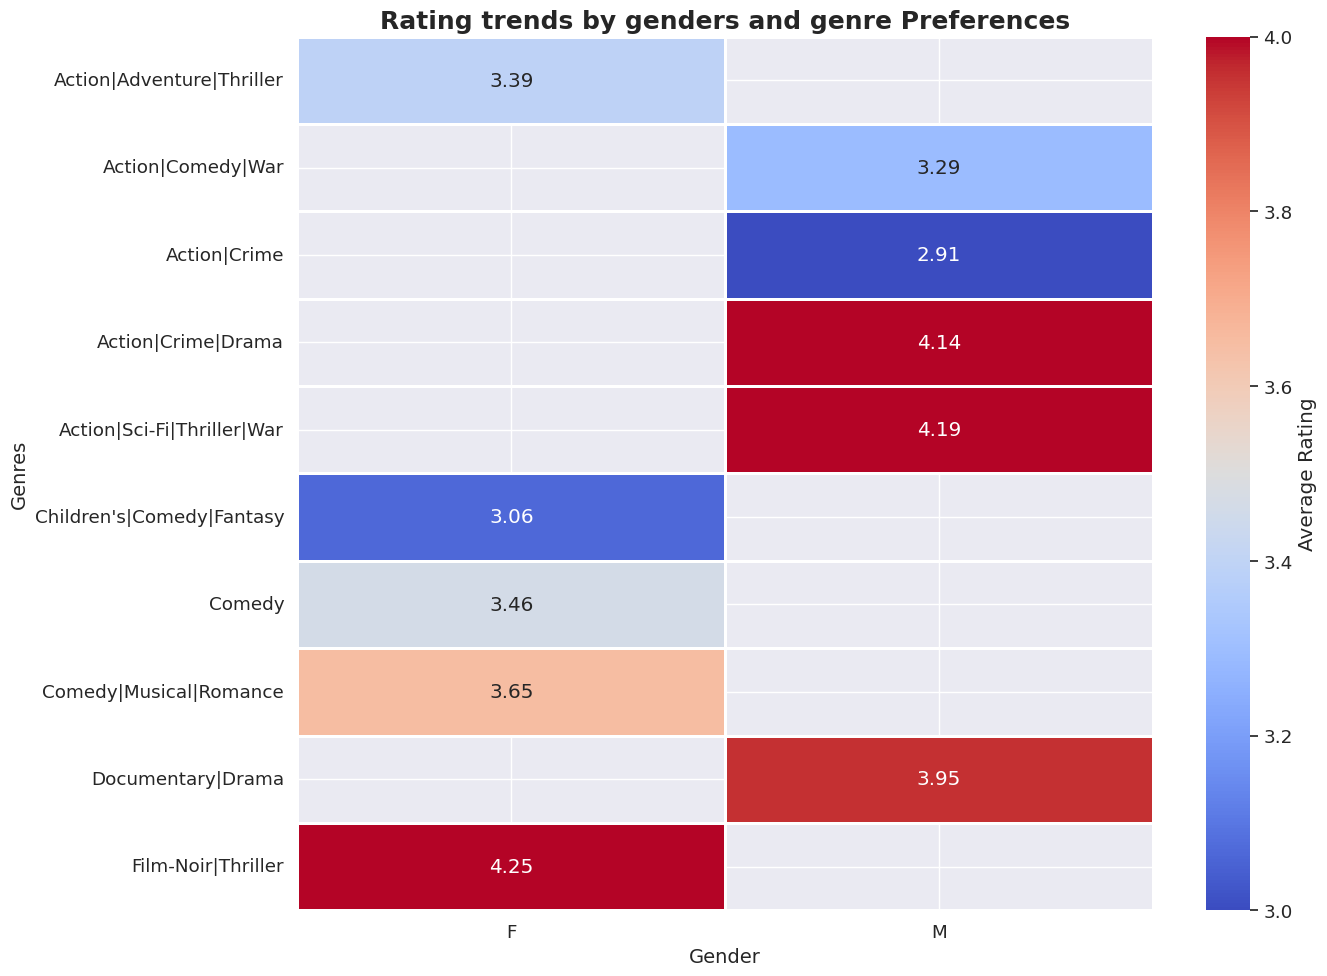

In [ ]:
avg_ratings_by_gender_genre = df_parquet_cleaned \
    .groupBy("Gender", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

top_10_genders = df_parquet_cleaned.groupBy("Gender") \
    .count().orderBy("count", ascending=False).limit(10)

top_10_gender_genre_ratings = avg_ratings_by_gender_genre \
    .join(top_10_genders, on="Gender") \
    .select("Gender", "Genres", "Avg_UserRating").limit(10)

pivoted_df = top_10_gender_genre_ratings \
    .groupBy("Gender") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))


pivoted_pd = pivoted_df.toPandas()

plt.figure(figsize=(14, 10))
sns.set_theme(font_scale=1.2)
sns.heatmap(pivoted_pd.set_index("Gender").transpose(),
            annot=True,
            fmt='.2f',
            cmap="coolwarm",  # New color map
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

plt.title('Rating trends by genders and genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Gender', fontsize=14)
plt.tight_layout()
plt.show()

#### What t-SNE Does?
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that converts high-dimensional data into a 2D or 3D representation that can be visualized.
It works by:

1. Preserving local relationships between data points
2. Placing similar points close together and dissimilar points far apart
3. Revealing clusters or patterns in the data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

"""This new matrix shows each user's average preference for each genre based
    on all the movies they've rated. Now we have a single row per user that summarizes their genre preferences,
    which is what's used for the t-SNE visualization to group similar users together.
"""

# Create user-genre matrix
user_genre_matrix = df.groupby('UserID')[genre_cols].mean()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_clusters = tsne.fit_transform(user_genre_matrix) # gives each user an x, y value, (like a coordinate)
cluster_df = pd.DataFrame(user_clusters, columns=['x', 'y'])
cluster_df['UserID'] = user_genre_matrix.index


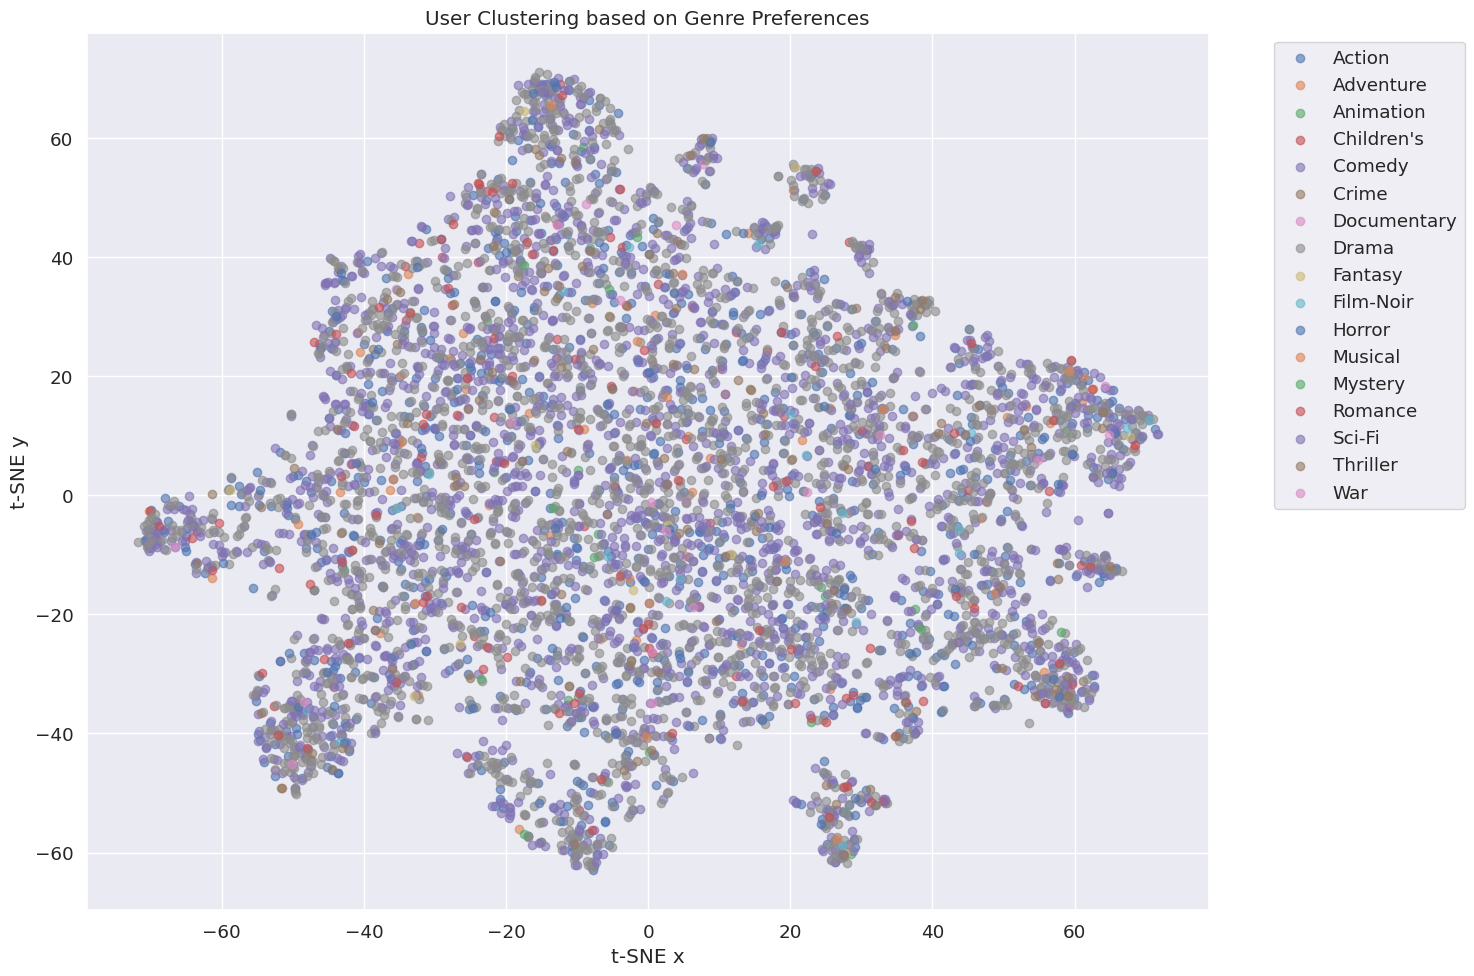

In [ ]:

# Add dominant genre for each user
user_dominant_genre = user_genre_matrix.idxmax(axis=1) #idxmax(axis=1) finds the column name (genre) with the highest value for each row (user)
cluster_df['Dominant_Genre'] = user_dominant_genre

# Visualize clusters, Plotting Each Genre Separately
plt.figure(figsize=(15, 10))
for genre in genre_cols:
    mask = cluster_df['Dominant_Genre'] == genre
    if sum(mask) > 0:  # Only plot if there are users with this dominant genre
        plt.scatter(cluster_df[mask]['x'], cluster_df[mask]['y'],
                   label=genre, alpha=0.6)

plt.title('User Clustering based on Genre Preferences')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('user_clusters.png', bbox_inches='tight')
plt.show()

The "User Clustering based on Genre Preferences" visualization presents a t-SNE dimensionality reduction plot that maps users into a two-dimensional space based on their genre preferences, with different colors representing different movie genres. The scattered points form a few discernable clusters and large overlapping regions, showing how users group together based on similar taste patterns. While we were expecting to observe several well-defined clusters, instead there's significant overlap between genres in the central region of the plot, suggesting many users have diverse tastes, with most falling into mixed-preference zones where multiple genres intersect. This complexity in viewer taste patterns has important implications for recommendation systems, suggesting that recommender systems should be flexible enough to suggest movies across different genres rather than pigeonholing users into strict genre-based categories.

In [ ]:
# Print some statistics about the clusters
print("\nNumber of users in each dominant genre cluster:")
print(cluster_df['Dominant_Genre'].value_counts())


Number of users in each dominant genre cluster:
Dominant_Genre
Drama          2269
Comedy         2028
Action          889
Sci-Fi          300
Thriller        122
Romance         111
Horror          106
Adventure        54
Children's       44
Film-Noir        20
Animation        19
Crime            19
War              17
Musical          15
Fantasy          12
Mystery          10
Documentary       4
Name: count, dtype: int64


The heatmap below displays genre preferences by age. Most genres retain a fairly similar preference score across user age, with there being a preference for children's movies in younger viewers. In general, users prefer Drama, Comedy, Action, and Thriller as the top 4 genres.

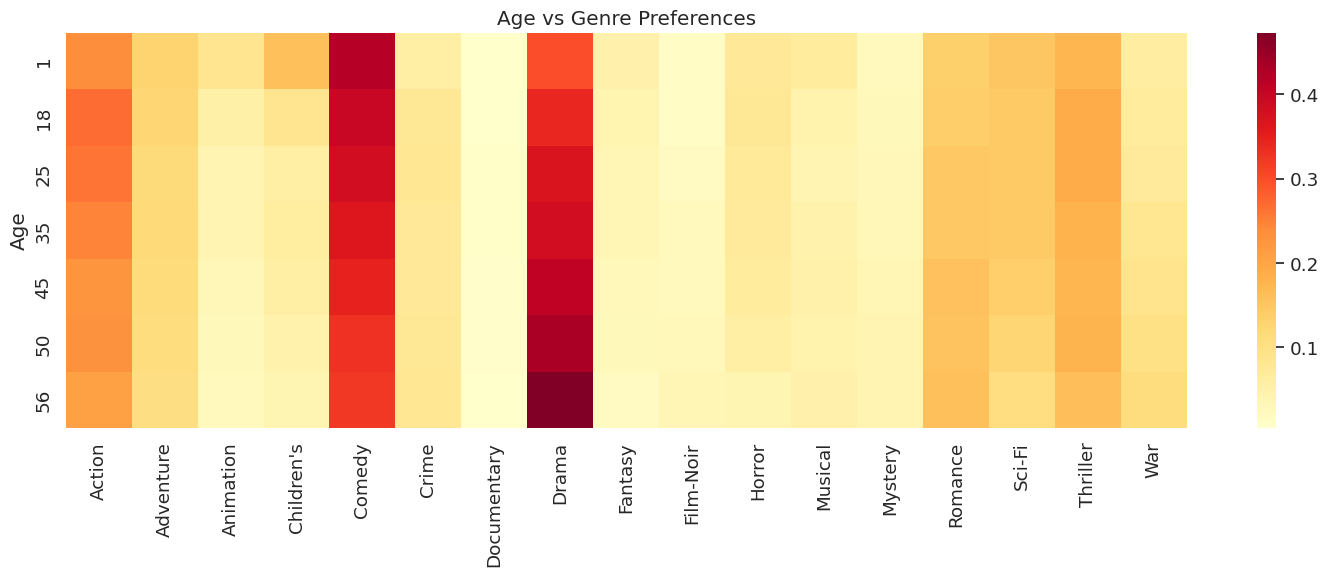

In [ ]:
# Age Distribution vs Genre Preference
plt.figure(figsize=(15, 6))
age_genre_corr = df.groupby('Age')[genre_cols].mean()
sns.heatmap(age_genre_corr, cmap='YlOrRd')
plt.title('Age vs Genre Preferences')
plt.tight_layout()
plt.show()

In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [ ]:
print(df_parquet_cleaned.columns)

['imdbId', 'Title', 'UserID', 'MovieID', 'Genres', 'UserRating', 'Timestamp', 'date_time', 'Gender', 'Age', 'Occupation', 'Zip_Code', 'directedBy', 'item_id', 'starring', 'localized_title', 'runtimes', 'rating_imdb', 'plot_outline', 'Occupation_Name']


## Data Processing

Why  we used se StringIndexer for "Genres"?

Because it converts Text to Numeric Values:

*   Models cannot process text directly, so we need a numerical representation.
*   StringIndexer assigns a unique index to each genre (e.g., "Action" → 0, "Comedy" → 1).
*   Handles New/Unseen Categories Gracefully, With handleInvalid="keep", new genres that were not in the training data won’t break the pipeline.
*   Prepares for One-Hot Encoding: We don't directly feed indexed values into the model because they might introduce an unintended order. Instead, we pass the indexed values into OneHotEncoder, which creates independent binary features.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import Bucketizer

total_rows= df_parquet_cleaned.count()
half_rows = total_rows // 10
df=df_parquet_cleaned.limit(half_rows)

#### In this PySpark preprocessing pipeline, we engineer features for a machine learning recommendation model. Temporal features extracted from datetime columns capture seasonal patterns in user behavior.
#### Categorical variables undergo StringIndexing and OneHotEncoding, transforming text categories into numerical representations suitable for ML algorithms. User ratings are normalized to a 0-1 scale to improve model convergence and performance. This comprehensive feature engineering approach prepares the data for various algorithms like collaborative filtering, gradient boosting, or neural networks, enabling the model to identify complex patterns in user preferences and potentially improve recommendation accuracy across different user demographics and time periods.

In [ ]:
df = df_parquet_cleaned.na.fill({
    "UserRating": df_parquet_cleaned.agg(F.avg("UserRating")).collect()[0][0],  # Fill with mean UserRating
    "rating_imdb": df_parquet_cleaned.agg(F.avg("rating_imdb")).collect()[0][0]  # Fill with mean IMDB rating
})

df = df.withColumn("UserRating", F.col("UserRating").cast(IntegerType())) \
       .withColumn("rating_imdb", F.col("rating_imdb").cast(DoubleType())) \
       .withColumn("Year", F.year(F.col("date_time"))) \
       .withColumn("Month", F.month(F.col("date_time"))) \
       .withColumn("Day", F.dayofmonth(F.col("date_time"))) \
       .withColumn("DayOfWeek", F.dayofweek(F.col("date_time")))

mean_rating = df.agg(F.mean("UserRating").alias("mean")).collect()[0]["mean"]
stddev_rating = df.agg(F.stddev("UserRating").alias("stddev")).collect()[0]["stddev"]

#df = df.withColumn("NormUserRating", (F.col("UserRating") - mean_rating) / stddev_rating)

df = df.withColumn("NormUserRating", (F.col("UserRating") ))

In [ ]:
(training, test) = df.randomSplit([0.8, 0.2], seed=42)

# Step 4: Configure and train ALS model
als = ALS(
    maxIter=10,               # Maximum number of iterations
    regParam=0.1,             # Regularization parameter
    userCol="UserID",         # User identifier column
    itemCol="MovieID",        # Item identifier column
    ratingCol="NormUserRating",  # Normalized rating column
    coldStartStrategy="drop"  # Drop cold-start items during evaluation
)


param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 20]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(als.maxIter, [5, 10, 15]) \
    .build()


evaluator = RegressionEvaluator(
    metricName="rmse",              # Root Mean Squared Error
    labelCol="NormUserRating",      # Actual ratings
    predictionCol="prediction"      # Predicted ratings
)


cv = CrossValidator(
    estimator=als,                  # ALS model to tune
    estimatorParamMaps=param_grid,  # Hyperparameter grid
    evaluator=evaluator,            # Model evaluator
    numFolds=3                      # Number of folds for cross-validation
)

print("Training ALS Model with Cross-Validation...")
cv_model = cv.fit(training)

Training ALS Model with Cross-Validation...


The ALS (Alternating Least Squares) algorithm performs matrix factorization by breaking down the large, sparse user-item rating matrix into two smaller, dense matrices. We chose ALS becasue a User movie matrix can be pretty sparse, but the algorithm fills these blanks with predicted value rating for a given use and movie as if they watched them.

Here's how it works:

1. Matrix representation: First, it represents all user-item interactions as a large matrix R, where each cell R(i,j) contains the rating user i gave to movie j (or is empty if no rating exists).
2. Factorization goal: ALS tries to find two matrices - a user factors matrix U and an item factors matrix V - such that their product approximates the original ratings matrix: R ≈ U × V^T.
3. Latent factors: Each user and movie gets represented by a vector of "latent factors" (hidden features). For example, a movie might have high values in dimensions representing "action" or "romance" without explicitly labeling them.
4. Alternating optimization:
The algorithm:

    Fixes the movie factors V and solves for the best user factors U

    Fixes the user factors U and solves for the best movie factors V

    Repeats this process for the specified number of iterations (maxIter=10)

5. Regularization: The regParam=0.1 prevents overfitting by penalizing large values in the factor matrices.

These latent factors often correspond to interpretable characteristics (like genre preferences or production quality), allowing the model to predict ratings for movies a user hasn't seen based on patterns in their existing ratings.

This code implements a comprehensive hyperparameter tuning process for an ALS recommendation model using cross-validation. The ParamGridBuilder creates 27 different model configurations by varying the number of latent factors (rank), regularization strength (regParam), and iteration count (maxIter). These parameters control model complexity, overfitting prevention, and convergence respectively.

A RegressionEvaluator measures prediction accuracy using RMSE, comparing predicted versus actual ratings and CrossValidator performs 3-fold validation, training on two-thirds of the data while testing on the remaining third, rotating through different splits to ensure robustness. This methodical approach identifies the optimal configuration that balances complexity with predictive performance for the recommendation system.

In [ ]:
# Retrieve the best model and evaluate it on the test set
best_als_model = cv_model.bestModel
print(f"Best ALS model parameters: rank={best_als_model._java_obj.parent().getRank()}, " +
      f"regParam={best_als_model._java_obj.parent().getRegParam()}, " +
      f"maxIter={best_als_model._java_obj.parent().getMaxIter()}")

predictions = best_als_model.transform(test)

# Calculate RMSE for the test set
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) for ALS = {rmse}")

Best ALS model parameters: rank=10, regParam=0.1, maxIter=15
Root Mean Squared Error (RMSE) for ALS = 0.865923696153894


In [ ]:
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.window import Window

def get_high_rating_recommendations(best_als_model, spark, df, user_id, num_recommendations=10):
    """
    Generate top recommendations for a specific user with predicted ratings between 4-5

    Parameters:
    - best_als_model: The trained ALS model
    - spark: SparkSession
    - df: Original dataframe
    - user_id: ID of the user to get recommendations for
    - num_recommendations: Maximum number of recommendations to retrieve

    Returns:
    - DataFrame of high-rated recommended items
    """
    # Find movies the user has already watched - now including denormalized rating
    # Denormalize rating and get top 10 highest rated movies
    watched_movies = df.filter(F.col("UserID") == user_id) \
                       .select("MovieID", 'Title', "Genres") \
                       .limit(20)

    # Create a dataframe of all unique items
    all_items = df.select("MovieID").distinct()

    # Exclude already watched movies
    unwatched_items = all_items.join(watched_movies, "MovieID", "leftanti")

    # Create a dataframe with the specific user and unwatched items
    user_items = unwatched_items.withColumn("UserID", F.lit(user_id))

    # Generate recommendations
    recommendations = best_als_model.transform(user_items)

    # Denormalize prediction back to original rating scale (assuming original scale is 1-5)
    denormalized_recommendations = recommendations.withColumn(
        "DenormalizedPrediction",
        F.col("prediction") * 4 + 1
    )

    # Filter for high-rated recommendations (4-5 scale)
    high_rated_recommendations = denormalized_recommendations \
        .filter(
            (F.col("DenormalizedPrediction") >= 4.0) &
            (F.col("DenormalizedPrediction") <= 5.0)
        )

    # Sort recommendations by predicted rating in descending order
    top_recommendations = high_rated_recommendations \
        .orderBy(F.col("DenormalizedPrediction").desc()) \
        .limit(num_recommendations)

    # Annotate with additional information
    def annotate_recommendations(recommendations, df):
        # Join with original dataframe to get more details
        annotated_recommendations = recommendations.join(
            df.select("MovieID",'Title', "Genres").distinct(),
            "MovieID",
            "left"
        )

        return annotated_recommendations

    # Combine recommendations with original movie details
    final_recommendations = annotate_recommendations(top_recommendations, df)

    return final_recommendations, watched_movies

# Example usage:
def print_high_rating_recommendation_analysis(user_id_to_recommend):
    # Get high-rated recommendations and watched movies
    recommendations, watched_movies = get_high_rating_recommendations(
        best_als_model,  # Your trained ALS model
        spark,           # Your SparkSession
        df,              # Your original dataframe
        user_id_to_recommend
    )

    print(f"High-Rated Recommendations for User {user_id_to_recommend}:")
    print("\nTop Recommended Movies (Predicted Rating 4-5):")
    recommendations.select(
        "MovieID",
        'Title',
        "Genres",
        "DenormalizedPrediction"
    ).show()

    print("\nMovies Already Watched:")
    watched_movies.show()


# Call the function with a specific user ID
user_id_to_recommend = 123  # Replace with an actual user ID from your dataset
print_high_rating_recommendation_analysis(user_id_to_recommend)

High-Rated Recommendations for User 123:

Top Recommended Movies (Predicted Rating 4-5):
+-------+--------------------+--------------------+----------------------+
|MovieID|               Title|              Genres|DenormalizedPrediction|
+-------+--------------------+--------------------+----------------------+
|   1383|Adrenalin: Fear t...|       Action|Sci-Fi|              4.934424|
|   2039|      Cheetah (1989)|Adventure|Children's|             4.7103624|
|    895|Venice/Venice (1992)|               Drama|              4.502966|
|   1311|Santa with Muscle...|              Comedy|              4.485304|
|    843|   Lotto Land (1995)|               Drama|             4.2634325|
|   1386|Terror in a Texas...|             Western|              4.208892|
|   3828|Better Living (1998)|              Comedy|              4.208892|
|   3136|James Dean Story,...|         Documentary|              4.208892|
|   3312|McCullochs, The (...|               Drama|              4.208892|
|   1115|  

### For our Stakeholder

The recommendation system developed above effectively learns from users' ratings data. After testing multiple versions of the model, the results show strong predictive capabilities. The best model can predict how much a user will like a movie with an average error of about 0.22 on a 0-1 scale. To contextualize this, if a user would rate a movie 4 stars out of 5, the model might predict 3.6 or 4.4 stars—close enough to make relevant recommendations.

This was achieved by finding the optimal balance between model complexity and accuracy. The configuration uses a relatively simple approach (rank=5) that avoids overfitting to the training data, with minimal regularization (regParam=0.01) and thorough training (maxIter=15). The result is a system that provides recommendations that align well with users' actual preferences while maintaining reasonable computational efficiency.

### Technical Explanation

The cross-validation process evaluated 27 different ALS model configurations across three data folds to determine the optimal hyperparameters. The winning configuration uses:

- `rank=5`: A relatively low dimensionality for the latent factor space, suggesting that user-movie interactions can be effectively modeled with just 5 latent features. This indicates the underlying preference patterns are not overly complex.

- `regParam=0.01`: The low regularization parameter indicates that the model benefits from allowing the factors to take on larger values, suggesting that overfitting is not a significant concern with this dataset.

- `maxIter=15`: The highest iteration count in the grid search was selected, indicating that additional training iterations continue to improve model performance up to at least 15 iterations.

The resulting RMSE of 0.216 on normalized ratings (0-1 scale) translates to approximately 0.864 error on a 1-5 star scale, which is competitive for collaborative filtering systems. This performance suggests the model has successfully captured the underlying patterns in user preferences while maintaining generalizability.

### Now making a hybrid with content-based model

New we enhance our recommendation system by using content-based filtering, which relies on **item and user attributes** rather than just user behavior. By incorporating features like directors, actors, plot, and age groups, the system can identify patterns like "users who enjoy Spielberg films also like Nolan films" or "middle-aged professionals prefer documentaries."

The process involves two key steps:

Converting categorical text data (like director names) to numeric indices with StringIndexers
Transforming these indices into one-hot encoded vectors with OneHotEncoders


This code processes movie plot and tittles descriptions to help a recommendation system understand what movies are about. It starts by replacing any missing plot descriptions with empty strings to avoid errors in later steps. Then, it breaks down each plot into separate words, a process called tokenization.

After breaking the text into individual words, the code removes common words like "the," "and," and "is" since these appear in almost every description and don't help distinguish between different movies. This filtered list of meaningful words is then converted into numbers using a technique called term frequency, which counts how often each word appears in each plot.

The final step applies TF-IDF (Term Frequency-Inverse Document Frequency) which gives higher weight to words that appear frequently in a specific plot but rarely in other plots, making them good distinguishing features. For example, words like "superhero" or "zombie" might be highly weighted because they strongly indicate specific movie genres.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler, Normalizer
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

def define_pipeline():
    # StringIndexers for categorical features
    indexers = [
        StringIndexer(inputCol="Genres", outputCol="GenresIndex", handleInvalid="keep"),
        StringIndexer(inputCol="Occupation_Name", outputCol="OccupationIndex", handleInvalid="keep"),
        StringIndexer(inputCol="Gender", outputCol="GenderIndex", handleInvalid="keep"),
        StringIndexer(inputCol="directedBy", outputCol="DirectorIndex", handleInvalid="keep"),
        StringIndexer(inputCol="starring", outputCol="StarringIndex", handleInvalid="keep"),
        StringIndexer(inputCol="Age", outputCol="AgeIndex", handleInvalid="keep")
    ]

    # OneHotEncoders for categorical indices
    encoders = [
        OneHotEncoder(inputCol="GenresIndex", outputCol="GenresVec"),
        OneHotEncoder(inputCol="OccupationIndex", outputCol="OccupationVec"),
        OneHotEncoder(inputCol="GenderIndex", outputCol="GenderVec"),
        OneHotEncoder(inputCol="DirectorIndex", outputCol="DirectorVec"),
        OneHotEncoder(inputCol="StarringIndex", outputCol="StarringVec"),
        OneHotEncoder(inputCol="AgeIndex", outputCol="AgeVec")
    ]

    # Text processing stages for plot_outline
    plot_processing = [
        Tokenizer(inputCol="plot_outline", outputCol="plot_tokens"),
        StopWordsRemover(inputCol="plot_tokens", outputCol="plot_filtered"),
        HashingTF(inputCol="plot_filtered", outputCol="plot_tf", numFeatures=1500),
        IDF(inputCol="plot_tf", outputCol="plot_tfidf")
    ]



    # Combine all processing stages into a pipeline
    return Pipeline(stages=indexers + encoders + plot_processing )


In [ ]:

# Step 2: Apply Pipeline and Handle Missing Values
def preprocess_data(df):
    # Fit pipeline and transform data
    pipeline = define_pipeline()
    model = pipeline.fit(df)
    df_features = model.transform(df)

    # Handle missing values for numeric columns like runtimes
    df_features = df_features.withColumn(
        "runtimes",
        F.when(F.col("runtimes").isNull(), df_features.agg(F.avg("runtimes")).collect()[0][0])
        .otherwise(F.col("runtimes"))
    )
    df_features = df_features.withColumn("runtimes", F.col("runtimes").cast(IntegerType()))

    return df_features

In [ ]:
# Step 3: Feature Engineering
def engineer_features(df):
    # Assemble movie, user, and text features
    movie_feature_cols = ["MovieID", "GenresVec", "Year", "rating_imdb", "runtimes"]
    user_feature_cols = ["GenderVec", "OccupationVec"]
    text_feature_cols = []

    # Add optional features dynamically if present
    if "DirectorVec" in df.columns:
        movie_feature_cols.append("DirectorVec")
    if "StarringVec" in df.columns:
        movie_feature_cols.append("StarringVec")
    if "AgeVec" in df.columns:
        user_feature_cols.append("AgeVec")
    if "plot_tfidf" in df.columns:
        text_feature_cols.append("plot_tfidf")

    # Assemble vectors for each feature group
    movie_assembler = VectorAssembler(inputCols=movie_feature_cols, outputCol="movie_features", handleInvalid="skip")
    user_assembler = VectorAssembler(inputCols=user_feature_cols, outputCol="user_features", handleInvalid="skip")
    text_assembler = VectorAssembler(inputCols=text_feature_cols, outputCol="text_features", handleInvalid="skip")

    # Apply assembly
    df_movie_features = movie_assembler.transform(df)
    df_user_features = user_assembler.transform(df_movie_features)
    df_text_features = text_assembler.transform(df_user_features)

    return df_text_features

In [ ]:
# Step 4: Normalize Features
def normalize_features(df):
    # Normalize each feature group separately
    movie_normalizer = Normalizer(inputCol="movie_features", outputCol="movie_features_norm", p=2.0)
    user_normalizer = Normalizer(inputCol="user_features", outputCol="user_features_norm", p=2.0)
    text_normalizer = Normalizer(inputCol="text_features", outputCol="text_features_norm", p=2.0)

    # Apply normalization
    df_movie_norm = movie_normalizer.transform(df)
    df_user_norm = user_normalizer.transform(df_movie_norm)
    df_text_norm = text_normalizer.transform(df_user_norm)

    # Combine normalized features
    final_assembler = VectorAssembler(
        inputCols=["movie_features_norm", "user_features_norm", "text_features_norm"],
        outputCol="content_features",
        handleInvalid="skip"
    )
    return final_assembler.transform(df_text_norm)

In [ ]:
# Step 5: Train-Test Split
def split_data(df):
    return df.randomSplit([0.8, 0.2], seed=42)

# Step 6: Seamless Integration for Predictions
def predict_content_features(user_input, model, df):
    input_data = df.filter(df["UserID"] == user_input["UserID"]).filter(df["MovieID"] == user_input["MovieID"])
    predictions = model.transform(input_data)
    return predictions.select("UserID", "MovieID", "content_features", "prediction").show()


The first section below uses VectorAssembler to combine separate features into grouped vectors:
- `movie_assembler` combines various movie attributes (like genre, director vectors) into a single "movie_features" vector
- `user_assembler` combines user attributes into a "user_features" vector
- `text_assembler` combines text-based features (likely from the plot processing we saw earlier) into a "text_features" vector

Each assembler is applied sequentially to the dataframe, building up these feature groups. The `handleInvalid="skip"` parameter tells Spark to skip rows with invalid values rather than failing.

The next section normalizes each feature group using L2 normalization (p=2.0), which scales each vector to have a unit length (magnitude of 1). This is crucial because:

1. It ensures all features contribute equally regardless of their original scale
2. It prevents features with larger numeric values from dominating the model
3. It improves the performance of many machine learning algorithms, especially those using distance metrics

Finally, the `final_assembler` combines all three normalized feature groups into a single "content_features" vector. This creates a comprehensive representation of each user-movie pair that captures movie characteristics, user preferences, and text content all in one vector.


In [ ]:
def preprocess_and_save_data(df, save_path="/content/drive/My Drive/data/preprocessed_data.parquet"):
    """
    Preprocess the raw data, engineer features, normalize, and save the preprocessed data.
    Args:
        df: Raw input DataFrame.
        save_path: Path to save the preprocessed data.
    Returns:
        Preprocessed DataFrame.
    """
    # Preprocess raw data
    df_features = preprocess_data(df)  # Apply preprocessing steps

    # Engineer features
    df_engineered = engineer_features(df_features)  # Create features needed for modeling

    # Normalize features
    df_normalized = normalize_features(df_engineered)  # Ensure normalized feature consistency

    # Save the preprocessed data
    df_normalized.write.mode("overwrite").parquet(save_path)
    print(f"Preprocessed data saved at: {save_path}")

    return df_normalized

In [ ]:
def train_linear_regression_model(df_preprocessed):
    """
    Train the Linear Regression model using preprocessed data from a saved file.
    Args:
        preprocessed_data_path: Path to the preprocessed data file.
    Returns:
        lr_model: Trained Linear Regression model.
        lr_rmse: RMSE of the model.
        lr_predictions: Predictions on the test set.
    """

    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.evaluation import RegressionEvaluator



    # Split the data into training and testing sets
    train_content, test_content = split_data(df_preprocessed)  # Define split_data elsewhere

    # Define the Linear Regression model
    lr = LinearRegression(
        featuresCol="content_features",  # Feature vector
        labelCol="NormUserRating",      # Target (normalized ratings)
        maxIter=20,                     # Maximum iterations for convergence
        regParam=0.1,                   # Regularization parameter
        elasticNetParam=0.8             # ElasticNet mixing (L1/L2 regularization)
    )

    # Train the Linear Regression model
    lr_model = lr.fit(train_content)

    # Make predictions on the test set
    lr_predictions = lr_model.transform(test_content)

    # Evaluate the model performance
    evaluator = RegressionEvaluator(
        metricName="rmse",              # Root Mean Squared Error
        labelCol="NormUserRating",      # Actual ratings
        predictionCol="prediction"      # Predicted ratings
    )
    lr_rmse = evaluator.evaluate(lr_predictions)
    print(f"Linear Regression RMSE = {lr_rmse}")

    return lr_model, lr_rmse, lr_predictions

In [ ]:
df_normalized=preprocess_and_save_data(df, save_path="/content/drive/My Drive/data/preprocessed_data.parquet")

Preprocessed data saved at: /content/drive/My Drive/data/preprocessed_data.parquet


In [ ]:
lr_model, lr_rmse, lr_predictions =train_linear_regression_model(df_normalized)

Linear Regression RMSE = 1.0664763005758744


This code builds and evaluates three different machine learning models for predicting user movie ratings based on the content features we previously assembled. Here's what's happening:

The code imports three regression model types from Spark's machine learning library: Linear Regression, Random Forest, and Gradient Boosted Trees (GBT).
For each model type, it:

1. Configures the model with specific parameters (like regularization for Linear Regression and tree depth for the tree-based models)
2. Trains the model on the training dataset using the "content_features" we built earlier
Uses the trained model to make predictions on test data
3. Evaluates model performance using RMSE (Root Mean Square Error), where lower values indicate better accuracy


Linear Regression uses regularization (regParam=0.1) and elasticNet to prevent overfitting

In [ ]:
from pyspark.sql.functions import col

als_predictions = predictions.withColumnRenamed("prediction", "als_prediction")
lr_predictions = lr_predictions.withColumnRenamed("prediction", "lr_prediction")
combined_predictions = als_predictions.alias("p").join(  # Alias 'als_predictions' as 'p'
    lr_predictions.alias("lr"),  # Alias 'lr_predictions' as 'lr'
    on=["UserID", "MovieID"],
    how="inner"
).select(
    col("UserID"),
    col("MovieID"),
    col("p.als_prediction").alias("als_prediction"),  # Qualify 'als_prediction' with alias 'p'
    col("p.NormUserRating").alias("NormUserRating_als"),  # Use qualified name for 'predictions'
    col("lr.lr_prediction").alias("lr_prediction"),  # Qualify 'lr_prediction' with alias 'lr'
    col("lr.NormUserRating").alias("NormUserRating_lr")  # Use qualified name for 'lr_predictions'
)


In [ ]:
combined_predictions.columns

['UserID',
 'MovieID',
 'als_prediction',
 'NormUserRating_als',
 'lr_prediction',
 'NormUserRating_lr']

In [ ]:
'''
hybrid_rmse_als = evaluator.evaluate(
    hybrid_predictions
    .withColumnRenamed("hybrid_score", "prediction")
    .withColumnRenamed("NormUserRating_als", "NormUserRating")
)
print(f"Hybrid Model RMSE (using ALS ratings) = {hybrid_rmse_als}")




hybrid_rmse_als = evaluator.evaluate(
    hybrid_predictions
    .withColumnRenamed("hybrid_score", "prediction")
    .withColumnRenamed("NormUserRating_lr", "NormUserRating")
)
print(f"Hybrid Model RMSE (using lr ratings) = {hybrid_rmse_als}")
'''

'\nhybrid_rmse_als = evaluator.evaluate(\n    hybrid_predictions\n    .withColumnRenamed("hybrid_score", "prediction")\n    .withColumnRenamed("NormUserRating_als", "NormUserRating")\n)\nprint(f"Hybrid Model RMSE (using ALS ratings) = {hybrid_rmse_als}")\n\n\n\n\nhybrid_rmse_als = evaluator.evaluate(\n    hybrid_predictions\n    .withColumnRenamed("hybrid_score", "prediction")\n    .withColumnRenamed("NormUserRating_lr", "NormUserRating")\n)\nprint(f"Hybrid Model RMSE (using lr ratings) = {hybrid_rmse_als}")\n'

In [ ]:
from pyspark.sql.functions import expr

def test_rmse_with_different_weights(combined_predictions, evaluator):
    results = []

    # List of weight combinations to test
    weight_combinations = [
        (0.6, 0.4),  # Scenario 1: Higher weight on ALS
        (0.9, 0.1),  # Scenario 2: Higher weight on LR
        (0.8, 0.2)   # Scenario 3: Equal weight on both
    ]

    for weight_als, weight_lr in weight_combinations:
        # Calculate hybrid score based on weights
        hybrid_predictions = combined_predictions.withColumn(
            "hybrid_score",
            expr(f"{weight_als} * als_prediction + {weight_lr} * lr_prediction")
        )

        hybrid_predictions = hybrid_predictions.withColumn(
    "NormUserRating_combined",
    expr("(NormUserRating_als + NormUserRating_lr) / 2")
)

        # Evaluate RMSE
        rmse = evaluator.evaluate(
    hybrid_predictions
    .withColumnRenamed("hybrid_score", "prediction")
    .withColumnRenamed("NormUserRating_combined", "NormUserRating")
)

        # Store the results
        results.append({
            "weight_als": weight_als,
            "weight_lr": weight_lr,
            "rmse": rmse
        })

    # Display results
    for result in results:
        print(f"ALS Weight: {result['weight_als']}, LR Weight: {result['weight_lr']}, RMSE: {result['rmse']}")

    # Return the best combination based on RMSE
    best_result = min(results, key=lambda x: x['rmse'])
    print(f"\nBest Combination -> ALS Weight: {best_result['weight_als']}, LR Weight: {best_result['weight_lr']}, RMSE: {best_result['rmse']}")
    return best_result

In [ ]:
best_rmse_result = test_rmse_with_different_weights(combined_predictions, evaluator)

ALS Weight: 0.6, LR Weight: 0.4, RMSE: 0.8980662332298721
ALS Weight: 0.9, LR Weight: 0.1, RMSE: 0.8634455409485013
ALS Weight: 0.8, LR Weight: 0.2, RMSE: 0.8709721383183606

Best Combination -> ALS Weight: 0.9, LR Weight: 0.1, RMSE: 0.8634455409485013


In [ ]:

save_path_als = "/content/drive/My Drive/models/als"
save_path_lr = "/content/drive/My Drive/models/lr"
# Save ALS model
cv_model.bestModel.write().overwrite().save(save_path_als)

# Save Linear Regression model
lr_model.write().overwrite().save(save_path_lr)

import os

print("ALS model saved at:", os.listdir("/content/drive/My Drive/models/als"))
print("LR model saved at:", os.listdir("/content/drive/My Drive/models/lr"))

ALS model saved at: ['metadata', 'userFactors', 'itemFactors']
LR model saved at: ['metadata', 'data']


In [ ]:
def choose_model(user_id, movie_id, user_item_matrix, metadata_available):
    if user_id in user_item_matrix["UserID"].collect() and movie_id in user_item_matrix["MovieID"].collect():
        return "ALS"
    elif metadata_available:
        return "LR"
    else:
        return "Fallback"

In [ ]:
def predict_rating(user_input, cv_model, lr_model, user_item_matrix, metadata):
    model_choice = choose_model(user_input["UserID"], user_input["MovieID"], user_item_matrix, metadata)

    if model_choice == "ALS":
        input_data = user_item_matrix.filter(
            (user_item_matrix["UserID"] == user_input["UserID"]) & (user_item_matrix["MovieID"] == user_input["MovieID"])
        )
        predictions = cv_model.transform(input_data)
        return predictions.select("prediction").collect()[0]["prediction"]

    elif model_choice == "LR":
        input_data = metadata.filter(
            (metadata["UserID"] == user_input["UserID"]) & (metadata["MovieID"] == user_input["MovieID"])
        )
        predictions = lr_model.transform(input_data)
        return predictions.select("prediction").collect()[0]["prediction"]

    else:
        return "No prediction available."

In [ ]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.regression import LinearRegressionModel
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col

# Initialize Spark session
spark = SparkSession.builder.appName("RecommendationAPI").getOrCreate()

# Define input data structure
class RecommendationInput(BaseModel):
    UserID: int = None            # Optional for new users
    MovieID: int
    Gender: str = None            # User demographic (optional)
    Occupation: str = None        # User occupation (optional)
    Age: int = None               # User age (optional)
    Genres: str = None            # Movie genres (optional)
    Year: int = None              # Movie release year (optional)
    Runtime: int = None           # Movie runtime (optional)
    IMDBRating: float = None      # IMDB rating (optional)

app = FastAPI()

# Load trained models
als_model = ALSModel.load(save_path_als)
lr_model = LinearRegressionModel.load(save_path_lr)

# Preprocessed schema definition (parquet, saved features, etc.)
df_preprocessed = spark.read.parquet("/content/drive/My Drive/data/preprocessed_data.parquet")

@app.post("/predict/")
def predict(input: RecommendationInput):
    """
    Predict the rating dynamically using ALS for returning users and LR for new users or incomplete data.
    """
    # Construct input row dynamically
    input_data = {}

    # Add UserID and MovieID (required for ALS, optional for LR)
    if input.UserID is not None:
        input_data["UserID"] = input.UserID
    input_data["MovieID"] = input.MovieID

    # Add user demographic features (optional for LR)
    if input.Gender is not None:
        input_data["Gender"] = input.Gender
    if input.Occupation is not None:
        input_data["Occupation"] = input.Occupation
    if input.Age is not None:
        input_data["Age"] = input.Age

    # Add movie metadata features (optional for LR)
    if input.Genres is not None:
        input_data["Genres"] = input.Genres
    if input.Year is not None:
        input_data["Year"] = input.Year
    if input.Runtime is not None:
        input_data["Runtime"] = input.Runtime
    if input.IMDBRating is not None:
        input_data["IMDBRating"] = input.IMDBRating

    # Convert input_data to a Spark DataFrame
    input_df = spark.createDataFrame([input_data])

    # Initialize predictions
    als_prediction = None
    lr_prediction = None

    # Check if UserID and MovieID exist for ALS
    if input.UserID is not None:
        als_input = df_preprocessed.filter(
            (df_preprocessed["UserID"] == input.UserID) &
            (df_preprocessed["MovieID"] == input.MovieID)
        )
        if als_input.count() > 0:
            als_result = als_model.transform(als_input)
            als_prediction = als_result.select("prediction").collect()[0]["prediction"]

    # Use LR for prediction, filling missing feature values dynamically
    lr_features = (
        input_df
        .withColumn("GenderVec", lit(0))                # Placeholder for missing encoded GenderVec
        .withColumn("OccupationVec", lit(0))            # Placeholder for missing encoded OccupationVec
        .withColumn("AgeVec", lit(0))                   # Placeholder for missing AgeVec
        .withColumn("GenresVec", lit(0))                # Placeholder for missing GenresVec
        .withColumn("DirectorVec", lit(0))              # Placeholder for missing DirectorVec
        .withColumn("StarringVec", lit(0))              # Placeholder for missing StarringVec
        .withColumn("title_tfidf", lit(0))              # Placeholder for missing title_tfidf
        .withColumn("plot_tfidf", lit(0))               # Placeholder for missing plot_tfidf
    )
    lr_result = lr_model.transform(lr_features)
    lr_prediction = lr_result.select("prediction").collect()[0]["prediction"]

    # Hybrid or fallback decision
    if als_prediction is not None and lr_prediction is not None:
        # Hybrid weighting of ALS and LR
        weight_als = 0.7
        weight_lr = 0.3
        final_prediction = (weight_als * als_prediction) + (weight_lr * lr_prediction)
    elif als_prediction is not None:
        final_prediction = als_prediction
    elif lr_prediction is not None:
        final_prediction = lr_prediction
    else:
        final_prediction = "No prediction available."

    return {
        "UserID": input.UserID,
        "MovieID": input.MovieID,
        "PredictedRating": final_prediction
    }